#### This one is sort of about the fact that G4 and CTCF tend to be cooriented (same strand) when they are near each other ...

#### important TODO - try to redefine "CTCF and G4" - to make them more proximal - but only if we decide to include it in the paper


In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
# G4-seq : G4 stalled at polymerase, more comprehensive list (hg19):
# G4-seq data https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63874
# ls ../GSE*bed.gz
# require tr -s '\t' - to remove duplicated tabs
# we've got + and - strand G4s separately ...
G4_minus_polstall = bioframe.read_table(
    "../GSE63874_Na_K_PDS_minus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = bioframe.read_table(
    "../GSE63874_Na_K_PDS_plus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = G4_plus_polstall.sort_values(["chrom","start"])
G4_plus_polstall = G4_plus_polstall[ G4_plus_polstall["chrom"].isin(autosomal_chroms) ]
G4_plus_polstall = G4_plus_polstall.reset_index(drop=True)
print(f"G4+ alone {len(G4_plus_polstall)} ...")

G4_minus_polstall = G4_minus_polstall.sort_values(["chrom","start"])
G4_minus_polstall = G4_minus_polstall[ G4_minus_polstall["chrom"].isin(autosomal_chroms) ]
G4_minus_polstall = G4_minus_polstall.reset_index(drop=True)
print(f"G4- alone {len(G4_minus_polstall)} ...")

G4_polstall = bf.merge(
    pd.concat([G4_plus_polstall,G4_minus_polstall]).reset_index(drop=True), # !!! Achtung !!! resetting_index is Yber important here!
#     min_dist=merge_radius
)
G4_polstall = G4_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
print(f"G4-+ together {len(G4_polstall)}, would have been {len(G4_plus_polstall)+len(G4_minus_polstall)} ...")

G4+ alone 198824 ...
G4- alone 195394 ...
G4-+ together 378344, would have been 394218 ...


### Figure 2 is based on several important BED-files ...

In [5]:
feat_names = OrderedDict()
# feat_names["ctcf"] = "intersect-all-NT-CTCF-NO-G4-centered"
# feat_names["ctcf_g4"] = "intersect-all-NT-CTCF-G4-centered"
feat_names["ctcf"] = "intersect-all-NT-CTCF-G4-centered"
# feat_names["g4"] = "intersect-G4-NO-CTCF-centered"

In [6]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    dfs[k] = bf.read_table(
        feat_names[k],
        names=["chrom","start","end"],
        usecols=(0,1,2),
        index_col=None
    )
    dfs[k] = dfs[k].sort_values(["chrom","start"])
    dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
    dfs[k] = dfs[k].reset_index(drop=True)
# merge_radius = 500
# df_merged = bf.merge(df, min_dist=merge_radius)
# print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")


## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [7]:
# # here is very-very liberal list of CTCF calls in hg19, based on "MA0139.1.meme" from JASPAR
# # P-val cutoff was 1e-4 - let's see how it looks here ...
# !scp ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/CTCF_motif/CTCF.hist.txt ./CTCF.MA0139.1.txt

# require tr -s '\t' - to remove duplicated tabs
ctcf_motif = bioframe.read_table(
    "CTCF.MA0139.1.txt",
    names=["name","chrom","start","end","strand","score","pval","seq"],
    sep="\t",
    index_col = None
)
ctcf_motif = ctcf_motif.sort_values(["chrom","start"])
ctcf_motif = ctcf_motif[ ctcf_motif["chrom"].isin(autosomal_chroms) ]
ctcf_motif = ctcf_motif.reset_index(drop=True)
# ctcf_motif = bf.merge(ctcf_motif, min_dist=merge_radius)
# ctcf_motif

good_pval = 2.6e-5
ctcf_motp = ctcf_motif[(ctcf_motif["strand"]=="+")&(ctcf_motif["pval"]<good_pval)][["chrom","start","end"]].reset_index(drop=True)
ctcf_motm = ctcf_motif[(ctcf_motif["strand"]=="-")&(ctcf_motif["pval"]<good_pval)][["chrom","start","end"]].reset_index(drop=True)

ctcfm = bioframe.overlap(dfs["ctcf"],ctcf_motm,how="inner",keep_order=True,suffixes=("","_mot"))[["chrom","start","end"]] \
    .drop_duplicates() \
    .reset_index(drop=True)
ctcfp = bioframe.overlap(dfs["ctcf"],ctcf_motp,how="inner",keep_order=True,suffixes=("","_mot"))[["chrom","start","end"]] \
    .drop_duplicates() \
    .reset_index(drop=True)

print(f"pval < {good_pval}")
print(f"we got {len(ctcfp)} +-s and {len(ctcfm)} --s")

# subtract them from each other to find G4-chipseq peaks that have a unique strand orientation:
_ctcfp = bioframe.subtract(ctcfp,ctcfm).reset_index(drop=True)
_ctcfm = bioframe.subtract(ctcfm,ctcfp).reset_index(drop=True)
# back to nice names after temporary ...
ctcfp = _ctcfp
ctcfm = _ctcfm
print(f"we got {len(ctcfp)} +-s and {len(ctcfm)} --s")

# add this CTCF by orientation into the dict:
feat_names["ctcfp"] = "ixxx"
feat_names["ctcfm"] = "ixxx"
dfs["ctcfp"] = ctcfp
dfs["ctcfm"] = ctcfm
# dfs["ctcf"] = ctcfp

pval < 2.6e-05
we got 1943 +-s and 1899 --s
we got 1239 +-s and 1195 --s


### keep G4 dormant for now ...

In [8]:
# G4df = bf.read_table(
#     feat_names["g4"],
#     names=["chrom","start","end"],
#     usecols=(0,1,2),
#     index_col=None
# )
# G4df = G4df.sort_values(["chrom","start"])
# G4df = G4df[G4df["chrom"].isin(autosomal_chroms)]
# G4df = G4df.reset_index(drop=True)
# # g4p = bioframe.overlap(G4df,G4_plus_polstall,keep_order=True)
# # g4m = bioframe.overlap(G4df,G4_minus_polstall,keep_order=True)
# # pd.merge(g4m,g4p,on=["chrom_1","start_1","end_1"],suffixes=('_m', '_p')).dropna(how="all",subset=["chrom_2_m","start_2_m","end_2_m","chrom_2_p","start_2_p","end_2_p"])

# # clean list of G4 chipseq peaks for which we can assign strand based on G4-stall data
# g4p = bioframe.overlap(G4df,G4_plus_polstall,how="inner",keep_order=True,suffixes=("","_stall"))[["chrom","start","end"]] \
#     .drop_duplicates() \
#     .reset_index(drop=True)

# # clean list of G4 chipseq peaks for which we can assign strand based on G4-stall data
# g4m = bioframe.overlap(G4df,G4_minus_polstall,how="inner",keep_order=True,suffixes=("","_stall"))[["chrom","start","end"]] \
#     .drop_duplicates() \
#     .reset_index(drop=True)

# print(f"we got {len(g4p)} +-s and {len(g4m)} --s")

# # subtract them from each other to find G4-chipseq peaks that have a unique strand orientation:
# _g4p = bioframe.subtract(g4p,g4m).reset_index(drop=True)
# _g4m = bioframe.subtract(g4m,g4p).reset_index(drop=True)
# # back to nice names after temporary ...
# g4p = _g4p
# g4m = _g4m
# print(f"we got {len(g4p)} +-s and {len(g4m)} --s")

# # add them to the main dict ...
# feat_names["g4p"] = "intersect-G4-NO-CTCF-centered"
# feat_names["g4m"] = "intersect-G4-NO-CTCF-centered"
# dfs["g4p"] = g4p
# dfs["g4m"] = g4m


### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


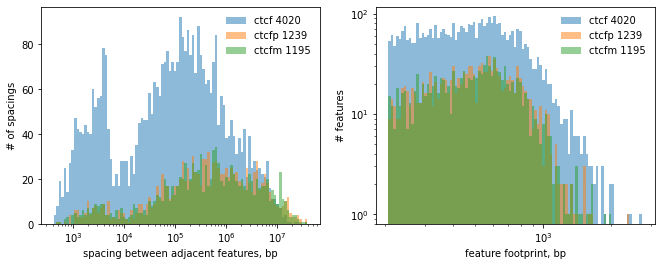

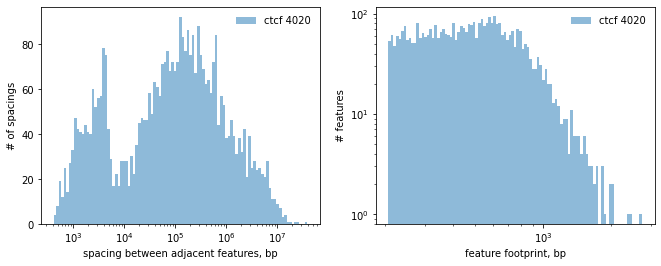

In [9]:
# just an overview of all of them together ...
plot_spacing_footprint_distros(dfs)
plot_spacing_footprint_distros({k:dfs[k] for k in ['ctcf']})
# plot_spacing_footprint_distros({k:dfs[k] for k in ['ctcf_g4']})
# plot_spacing_footprint_distros({k:dfs[k] for k in ['g4']})
# plot_spacing_footprint_distros({k:dfs[k] for k in ['allg4']})

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

### Not sure if we'd need to do it here, given the lare footprint of the G4 related peaks !!!...

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [10]:
#let's describe our samples that we want to have in Figure 1 ...
# fig2_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2","polII","mrna_ctcf","mrna_noctcf"] #,"ddx_CTCF","ddx_noCTCF"]
fig2_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2"] #,"ddx_CTCF","ddx_noCTCF"]

titles = fig2_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in fig2_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = None

### next is computation heavy step - stackups using bbi ...

In [11]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks( bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features ctcf:(4020) ...


stacking up ctcf ...
CPU times: user 655 ms, sys: 23.6 ms, total: 678 ms
Wall time: 675 ms
stacking up noctcf ...
CPU times: user 588 ms, sys: 27.4 ms, total: 615 ms
Wall time: 614 ms
stacking up rad21_CTCF ...
CPU times: user 656 ms, sys: 19.7 ms, total: 675 ms
Wall time: 674 ms
stacking up rad21_noCTCF ...
CPU times: user 495 ms, sys: 23.8 ms, total: 519 ms
Wall time: 519 ms
stacking up ins_CTCF ...
CPU times: user 449 ms, sys: 28 ms, total: 477 ms
Wall time: 476 ms
stacking up ins_noCTCF ...
CPU times: user 469 ms, sys: 8.03 ms, total: 477 ms
Wall time: 475 ms
stacking up G4a_r2 ...
CPU times: user 804 ms, sys: 19.9 ms, total: 824 ms
Wall time: 823 ms
going to stackup features ctcfp:(1239) ...


stacking up ctcf ...
CPU times: user 221 ms, sys: 0 ns, total: 221 ms
Wall time: 221 ms
stacking up noctcf ...
CPU times: user 180 ms, sys: 7.87 ms, total: 188 ms
Wall time: 191 ms
stacking up rad21_CTCF ...
CPU times: user 217 ms, sys: 4.02 ms, to

## we'll try 4C stackup visualization next

In [12]:
import cooler
# CkoCT442-IAA-pool.mcool
# CkoCT442-NT-pool.mcool

In [13]:
# Use bioframe to fetch the genomic features from the UCSC.

hg19_chromsizes = bioframe.fetch_chromsizes('hg19', as_bed=True)
hg19_cens = bioframe.fetch_centromeres('hg19')
hg19_arms = bioframe.split(hg19_chromsizes, hg19_cens, cols_points=['chrom', 'mid'])

# Select only arms of the chromosomes present in the cooler. 
# This step is typically not required; we call it only because the test data are reduced. 
hg19_arms = hg19_arms.set_index("chrom").loc[autosomal_chroms].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg19_arms = bioframe.parse_regions(hg19_arms)
# give concise names to chromosomal arms (p for short arm and q for long arm),
# this should be correct because chromosomes are ordered as in clr.chromnames and p->q is
# in the order of genomic coordinates:
hg19_arms["name"] = [f"{chrom}_{arm}" for chrom in autosomal_chroms for arm in list('pq')]
# # save it as a BED file
hg19_arms.to_csv("autosomal_hg19_arms.bed",sep="\t",index=False,header=False)

In [14]:
binsize = 10_000
fname = "CkoCT442-NT-pool.mcool"
clr_uri = f"{fname}::/resolutions/{binsize}"
clr = cooler.Cooler(clr_uri)

fname = "CkoCT442-IAA-pool.mcool"
clr_iaa_uri = f"{fname}::/resolutions/{binsize}"
clr_iaa = cooler.Cooler(clr_iaa_uri)

### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [15]:
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

# subtract = "mean_top"
# subtract_size = 7
for feature_key in stackup_dict:
    normalize_insulation_stackups_INPLACE(
        stackups_set = stackup_dict[feature_key],
        ins_keys = insulation_keys
    )

In [16]:
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.452,-.153)
    cmps[s] = cmapYlGnBu_r

In [17]:
# #### hold RNA-seq dormant for now ...

# # turn RNA-seq into log-scale ... - probably should use "norm" instead !!!!
# for s in ["mrna_ctcf", "mrna_noctcf"]:
#     limss[s] = (0.,3)    

# for k in dfs:
#     for s in ["mrna_ctcf", "mrna_noctcf"]:
#         stackup_dict[k][s] = np.log(stackup_dict[k][s])


In [28]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "wide_gene"
for k in dfs:
    print(f"stacking genes up for {k} ...")
    aaa = rstacks(
        "pcgene_plus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    bbb = rstacks(
        "pcgene_minus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    stackup_dict[k][feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
fig2_samples.append(feat_name)
titles = fig2_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

stacking genes up for ctcf ...
stacking genes up for ctcfp ...
stacking genes up for ctcfm ...


In [19]:
# takes a long time to compute !!!
# LET'S ADD Hi-C data AS YET ANOTHER STACKUP TO THE DICT ...
hic_flank = 100_000
for k in dfs:
    print(f"stacking 4C nt up for {k} ...")
    stackup_dict[k]["hic_nt"] = get_4cstackup(clr, dfs[k], flank=hic_flank)
    print(f"stacking 4C aux up for {k} ...")
    stackup_dict[k]["hic_aux"] = get_4cstackup(clr_iaa, dfs[k], flank=hic_flank)


stacking 4C nt up for ctcf ...
stacking 4C aux up for ctcf ...
stacking 4C nt up for ctcfp ...
stacking 4C aux up for ctcfp ...
stacking 4C nt up for ctcfm ...
stacking 4C aux up for ctcfm ...


In [20]:
#let's describe our samples that we want to have in Figure 1 ...
for s in ["hic_nt","hic_aux"]:
    fig2_samples.append(s)
    bw_fnames[s] = "coolerfname"
    binsizes[s] = clr.binsize # change to dict of coolers ...
    flanks[s] = hic_flank
    # for the Hi-C signal itself:
    limss[s] = (None,None)
    cmps[s] = "YlOrBr"
    norms[s] = colors.LogNorm(vmin=0.002,vmax=0.05)

titles = fig2_samples


In [21]:
# # LET'S ADD Hi-C data AS YET ANOTHER STACKUP TO THE DICT ...
# # hic_flank = 100_000

for s in ["hic_nt","hic_aux"]:
    # get average 4C profile - aka expected
    average_4C = []
    for k in ['ctcf',]:
        _ = np.nanmean( stackup_dict[k][s], axis=0 )
        average_4C.append(_)
    average_4C = np.nanmean(np.stack(average_4C),axis=0)
    # modify 4C stackups a bit ...
    for k in dfs:
        print(f"stacking 4C up for {k} ...")
        stackup_dict[k][f"{s}_oe"] = (stackup_dict[k][s]/average_4C)


#let's describe our samples that we want to have in Figure 1 ...
for s in ["hic_nt","hic_aux"]:
    s = f"{s}_oe"
    fig2_samples.append(s)
    bw_fnames[s] = "coolerfname"
    binsizes[s] = clr.binsize # change to dict of coolers ...
    flanks[s] = hic_flank
    # for Observed over Expected:
    limss[s] = (0,2)
    cmps[s] = "coolwarm"
    norms[s] = None
    titles = fig2_samples


stacking 4C up for ctcf ...
stacking 4C up for ctcfp ...
stacking 4C up for ctcfm ...
stacking 4C up for ctcf ...
stacking 4C up for ctcfp ...
stacking 4C up for ctcfm ...


In [22]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in stackup_dict:
    the_stackups = stackup_dict[feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = the_stackups['ctcf'].shape
    center_bin = int(width/2)
    the_stackups['ctcf_mean'] = np.nanmean(the_stackups['ctcf'][:,center_bin-1:center_bin+1],axis=1)
    # the_stackups['gene_mean'] = np.nanmean(the_stackups['gene'][:,:],axis=1)
    # the_stackups['rad21_mean'] = np.nanmean(the_stackups['rad21_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    _, _jjj = recursive_data_ordering(
        ks = [('ctcf_mean', "sort", 1, False)],
        idxs = np.arange( len(the_stackups['ctcf_mean']) ),
        data_dict = the_stackups,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj


sorting 4020 elements of ctcf_mean into 1 groups ...
sorting 1239 elements of ctcf_mean into 1 groups ...
sorting 1195 elements of ctcf_mean into 1 groups ...


### calculate running average (in chunks of 100) number of called peaks along the stackup

In [23]:
# #
# # skipping this for now ....
# #
CHUNK_SIZE = 100

# feature_keys = ['ctcf','ctcfp','ctcfm',  'ctcf_g4', 'g4',"g4p","g4m"]
feature_keys = ['ctcf','ctcfp','ctcfm']

# G4-seq (G4 with orientations ...)
G4p_sorted = {}
Number_of_chunks = {}
for feature_key in feature_keys:
    jjj = reordered_jdxs[feature_key]
    features_df = dfs[feature_key]
    # G4_polstall
    index_chunks = chunked(features_df.loc[jjj].index, CHUNK_SIZE)
    G4p_sorted[feature_key] = []
    Number_of_chunks[feature_key] = 0
    _df2 = G4_plus_polstall # works as is !!!
    for ii in index_chunks:
        _df1 = features_df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
        G4p_sorted[feature_key].append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
        Number_of_chunks[feature_key] += 1
        
G4m_sorted = {}
Number_of_chunks = {}
for feature_key in feature_keys:
    jjj = reordered_jdxs[feature_key]
    features_df = dfs[feature_key]
    # G4_polstall
    index_chunks = chunked(features_df.loc[jjj].index, CHUNK_SIZE)
    G4m_sorted[feature_key] = []
    Number_of_chunks[feature_key] = 0
    _df2 = G4_minus_polstall # works as is !!!
    for ii in index_chunks:
        _df1 = features_df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
        G4m_sorted[feature_key].append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
        Number_of_chunks[feature_key] += 1
        
# CTCF motif by orientation ...     
CTCFp_sorted = {}
Number_of_chunks = {}
for feature_key in feature_keys:
    jjj = reordered_jdxs[feature_key]
    features_df = dfs[feature_key]
    # G4_polstall
    index_chunks = chunked(features_df.loc[jjj].index, CHUNK_SIZE)
    CTCFp_sorted[feature_key] = []
    Number_of_chunks[feature_key] = 0
    _df2 = ctcf_motp # works as is !!!
    for ii in index_chunks:
        _df1 = features_df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
        CTCFp_sorted[feature_key].append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
        Number_of_chunks[feature_key] += 1
        
CTCFm_sorted = {}
Number_of_chunks = {}
for feature_key in feature_keys:
    jjj = reordered_jdxs[feature_key]
    features_df = dfs[feature_key]
    # G4_polstall
    index_chunks = chunked(features_df.loc[jjj].index, CHUNK_SIZE)
    CTCFm_sorted[feature_key] = []
    Number_of_chunks[feature_key] = 0
    _df2 = ctcf_motm # works as is !!!
    for ii in index_chunks:
        _df1 = features_df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
        CTCFm_sorted[feature_key].append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
        Number_of_chunks[feature_key] += 1

#### plotting those running averages is integrated into `plot_stackups` function ...

In [24]:
##############################################
# now we'll be plotting stackups for different feature independently ...
#############################################
print('ctcf', 'ctcf_g4', 'g4')

ctcf ctcf_g4 g4


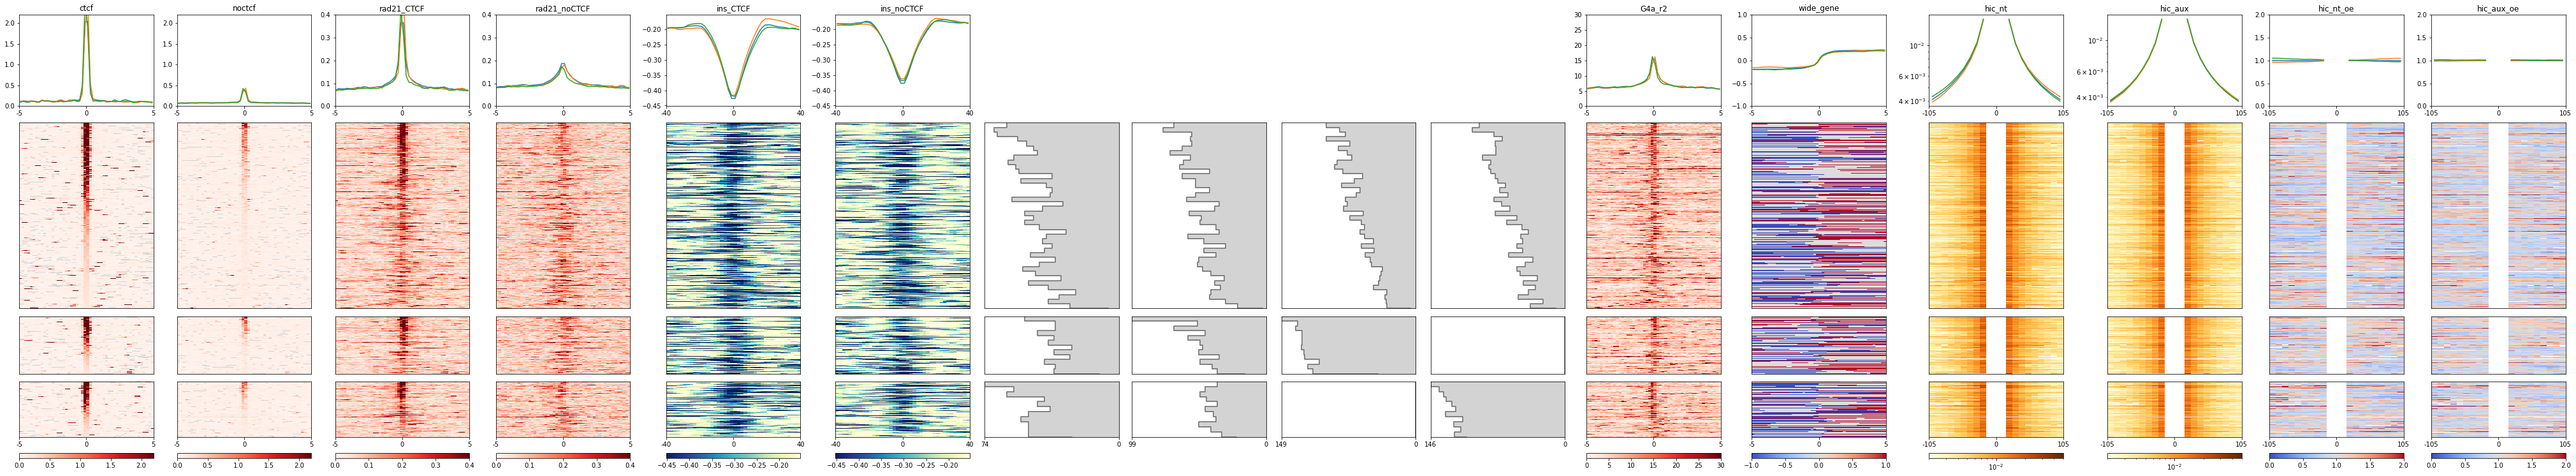

In [30]:
hmss = OrderedDict()

feature_keys = ['ctcf', 'ctcfp','ctcfm']
for feature_key in feature_keys:
    jjj = reordered_jdxs[feature_key]
    _stackups = stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in fig2_samples ]

_limss = [ limss[_k] for _k in fig2_samples ]
_cmps = [ cmps[_k] for _k in fig2_samples ]
_binsizes = [ binsizes[_k] for _k in fig2_samples ]
_norms = [ norms[_k] for _k in fig2_samples ]

# xtra_plots = [1,2]
extra_order = [6,7,8,9]
# hmss_order = [0,1,2,3,4,5,8,9,10,11,12,13,14,15,16]
hmss_order = [0,1,2,3,4,5,10,11,12,13,14,15]
assert len(hmss_order) == len(fig2_samples)
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group

# DEAL WITH XTRA PLOTS MANUALLY - AFTERWARDS ...

for col_index, y, width, color in [(extra_order[0], Number_of_chunks, G4p_sorted, "lightgrey"),
                                    (extra_order[1], Number_of_chunks, G4m_sorted, "lightgrey")]:
    common_width_max = max(max(width[k]) for k in width)
    for i, feature_key in enumerate(feature_keys):
        _y = np.arange(y[feature_key])
        _width = width[feature_key]
        _color = color
        xtra_axs[col_index][i].step(_width,_y,color="dimgray")
        xtra_axs[col_index][i].fill_betweenx(_y,0,_width,color=_color,step="post")
        xtra_axs[col_index][i].invert_yaxis()
        xtra_axs[col_index][i].invert_xaxis()
        xtra_axs[col_index][i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: f"{int(x*100)}"))
        xtra_axs[col_index][i].set_ylim(max(_y), 0)
        xtra_axs[col_index][i].set_xlim(common_width_max,0)
        xtra_axs[col_index][i].set_yticks([])
        xtra_axs[col_index][i].set_yticklabels([])   
        xtra_axs[col_index][i].set_xticks([])
        xtra_axs[col_index][i].set_xticklabels([])   
    xtra_axs[col_index][i].set_xticks([common_width_max,0])
    xtra_axs[col_index][i].set_xticklabels([common_width_max,0])

    

for col_index, y, width, color in [(extra_order[2], Number_of_chunks, CTCFp_sorted, "lightgrey"),
                                    (extra_order[3], Number_of_chunks, CTCFm_sorted, "lightgrey")]:
    common_width_max = max(max(width[k]) for k in width)
    for i, feature_key in enumerate(feature_keys):
        _y = np.arange(y[feature_key])
        _width = width[feature_key]
        _color = color
        xtra_axs[col_index][i].step(_width,_y,color="dimgray")
        xtra_axs[col_index][i].fill_betweenx(_y,0,_width,color=_color,step="post")
        xtra_axs[col_index][i].invert_yaxis()
        xtra_axs[col_index][i].invert_xaxis()
        xtra_axs[col_index][i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: f"{int(x*100)}"))
        xtra_axs[col_index][i].set_ylim(max(_y), 0)
        xtra_axs[col_index][i].set_xlim(common_width_max,0)
        xtra_axs[col_index][i].set_yticks([])
        xtra_axs[col_index][i].set_yticklabels([])   
        xtra_axs[col_index][i].set_xticks([])
        xtra_axs[col_index][i].set_xticklabels([])   
    xtra_axs[col_index][i].set_xticks([common_width_max,0])
    xtra_axs[col_index][i].set_xticklabels([common_width_max,0])
    

plt.savefig("Fig2.pdf")

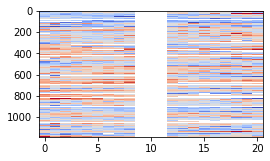

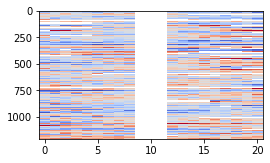

In [419]:
# ttt = stackup_dict["ctcf"]#.keys()
# aa = ttt['hic_nt_oe']
# bb = ttt['hic_aux_oe']
# plt.figure(figsize=(19,19))
# plt.imshow(bb/aa[reordered_jdxs["ctcf"]],aspect=0.01,interpolation="nearest",cmap="coolwarm",norm=colors.LogNorm(vmin=0.333,vmax=3))


ttt = stackup_dict["g4m"]#.keys()
aa = ttt['hic_nt_oe']
bb = ttt['hic_aux_oe']
plt.figure(figsize=(4,4))
plt.imshow(bb/aa[reordered_jdxs["g4m"]],aspect=0.01,interpolation="nearest",cmap="coolwarm",norm=colors.LogNorm(vmin=0.333,vmax=3))

ttt = stackup_dict["g4p"]#.keys()
aa = ttt['hic_nt_oe']
bb = ttt['hic_aux_oe']
plt.figure(figsize=(4,4))
plt.imshow(bb/aa[reordered_jdxs["g4p"]],aspect=0.01,interpolation="nearest",cmap="coolwarm",norm=colors.LogNorm(vmin=0.333,vmax=3))

In [77]:
# ###############################################################################
# ####
# #### LEGACY STACKUP PLOTTING SEPARATE FOR THE GROUPS ...
# ####
# ###############################################################################
# feature_key = 'ctcf'
# jjj = reordered_jdxs[feature_key]
# _stackups = stackup_dict[feature_key]
# hmss = [ _stackups[_k][jjj] for _k in fig2_samples ]
# _limss = [ limss[_k] for _k in fig2_samples ]
# _cmps = [ cmps[_k] for _k in fig2_samples ]
# _binsizes = [ binsizes[_k] for _k in fig2_samples ]
# _norms = [ norms[_k] for _k in fig2_samples ]

# xtra_plots = None
# plot_stackups(xtra_plots,hmss,titles,_limss,_cmps,_norms,_binsizes,fname=f"Fig2_{feature_key}.pdf",fillmissing=False,interpolation="nearest")

# feature_key = 'ctcf_g4'
# jjj = reordered_jdxs[feature_key]
# _stackups = stackup_dict[feature_key]
# hmss = [ _stackups[_k][jjj] for _k in fig2_samples ]
# _limss = [ limss[_k] for _k in fig2_samples ]
# _cmps = [ cmps[_k] for _k in fig2_samples ]
# _binsizes = [ binsizes[_k] for _k in fig2_samples ]
# _norms = [ norms[_k] for _k in fig2_samples ]

# xtra_plots = None
# plot_stackups(xtra_plots,hmss,titles,_limss,_cmps,_norms,_binsizes,fname=f"Fig2_{feature_key}.pdf",fillmissing=False,interpolation="nearest")

# feature_key = 'g4'
# jjj = reordered_jdxs[feature_key]
# _stackups = stackup_dict[feature_key]
# hmss = [ _stackups[_k][jjj] for _k in fig2_samples ]
# _limss = [ limss[_k] for _k in fig2_samples ]
# _cmps = [ cmps[_k] for _k in fig2_samples ]
# _binsizes = [ binsizes[_k] for _k in fig2_samples ]
# _norms = [ norms[_k] for _k in fig2_samples ]

# xtra_plots = None
# plot_stackups(xtra_plots,hmss,titles,_limss,_cmps,_norms,_binsizes,fname=f"Fig2_{feature_key}.pdf",fillmissing=False,interpolation="nearest")

In [18]:
# # check what we have here locally ...
# ! ls Fig2*pdf
# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021
# ! scp Fig2* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp masterlist*.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

### testing bigBed with super simple gene annotation data ...

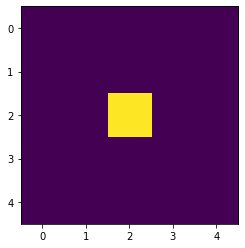

In [19]:
_k = np.ones((5,5))
_k[2,2] = 2
plt.imshow(_k)

In [20]:
from scipy.ndimage import convolve
bbb=convolve(np.clip(aaa.astype(float),0,1), _k, mode='constant', cval=0.0)

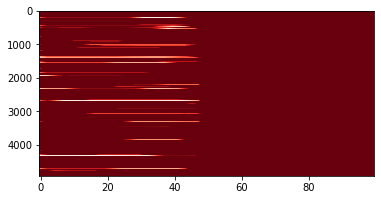

In [21]:
plt.imshow(bbb,aspect=0.01,cmap="Reds",vmin=0,vmax=1)

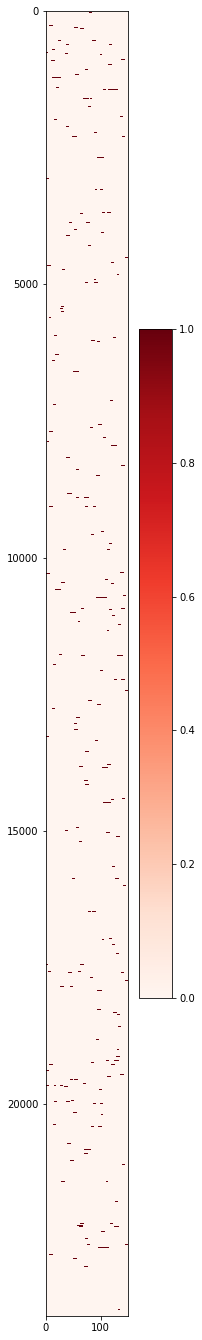

In [22]:
# SpliceDDX55aux.bb
# SpliceCTCFaux.bb
aaa = rstacks(
    "SpliceCTCFaux.bb",
    dfs["ctcf"],
    flank=15_000,
    binsize=200
)[reordered_jdxs["ctcf"]].astype(float)
bbb=convolve(np.clip(aaa.astype(float),0,1), _k, mode='constant', cval=0.0)
plt.figure(figsize=(4,24))
plt.imshow(bbb,aspect=0.1,interpolation="nearest",cmap="Reds",vmin=0,vmax=1)
plt.colorbar()

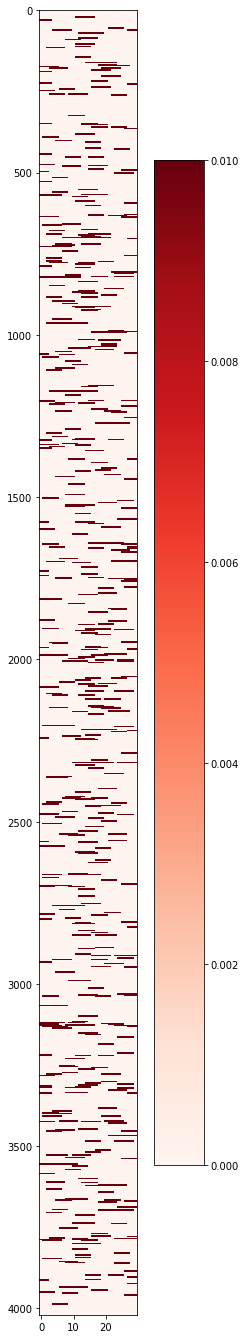

In [23]:
aaa = rstacks(
    "SpliceCTCFaux.bb",
    dfs["ctcf_g4"],
    flank=15_000,
    binsize=1_000
)[reordered_jdxs["ctcf_g4"]]
plt.figure(figsize=(6,24))
bbb=convolve(np.clip(aaa.astype(float),0,1), _k, mode='constant', cval=0.0)
plt.imshow(bbb,aspect=0.1,interpolation="none",cmap="Reds",vmin=0,vmax=.01)
plt.colorbar()

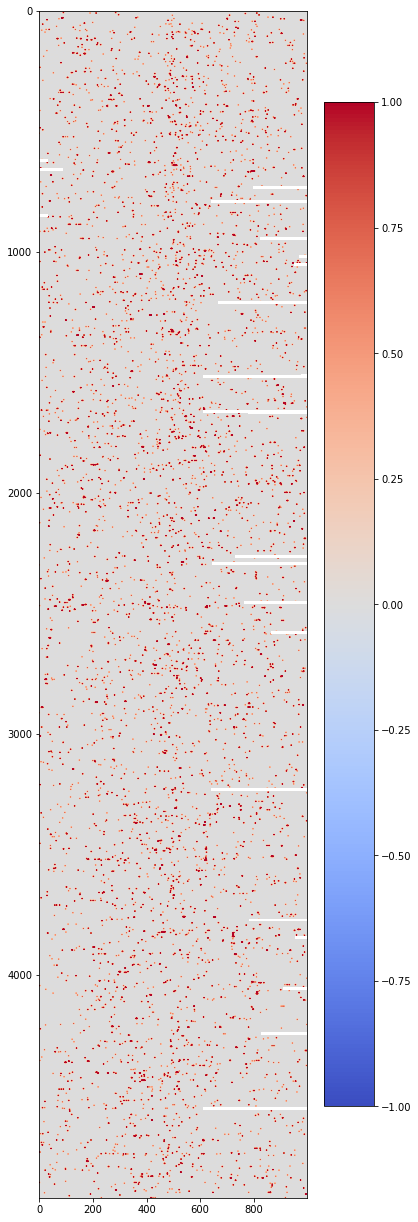

In [24]:
aaa = rstacks(
    "SpliceCTCFaux.bb",
    dfs["g4"],
    flank=250_000,
    binsize=500
)[reordered_jdxs["g4"]]
plt.figure(figsize=(6,42))
bbb=convolve(np.clip(aaa.astype(float),0,1), _k, mode='constant', cval=0.0)
plt.imshow(bbb,aspect=0.9,interpolation="bilinear",cmap="coolwarm",vmin=-1,vmax=1)
plt.colorbar()

In [351]:
# ## SCRAPE ALL OF THE ARM-LEVEL EXPECTED WORK FOR NOW:

# # calculate expected for the regions of interest:
# # this is a 10kb cooler file
# # and we should also have expected calculated for 10kb:
# !cooltools compute-expected \
#     --nproc 3 \
#     --output {fname}.10kb.exp.tsv \
#     --regions autosomal_hg19_arms.bed \
#     --contact-type cis \
#     --balance \
#     --weight-name weight \
#     --ignore-diags 2 \
#     {clr_uri}

# cis_exp = pd.read_csv("CkoCT442-NT-pool.mcool.10kb.exp.tsv",index_col=None,sep="\t")
# grp = cis_exp.groupby("region")

# grp.get_group("chr19_p").set_index("diag")["balanced.avg"][:20]

# import cooltools
# cooltools.lib.assign_regions(dfs["g4"],hg19_arms)

# flk = 5
# idx = clr.offset((c,s,e))
# mmm = clr.matrix()[idx,idx-flk:idx+flk+1][0]
# plt.plot(mmm,'o-')
# plt.plot(np.arange(len(mmm))[-flk-1:],mmm[-flk-1:])
# plt.plot(np.arange(len(mmm))[:flk+1],mmm[:flk+1])

# eee = grp.get_group("chr19_p").set_index("diag")["balanced.avg"].values[:flk+1]
# eee = np.r_[eee[::-1],eee[1:]]
# plt.plot(eee,'o-')



# # _k = "ctcf"
# # dfg4 = copy(dfs[_k])
# # anchor_center = 0.5*(dfs[_k]["start"]+dfs[_k]["end"])
# # anchor_center_binaligned = .5*(dfs[_k]["start"]+dfs[_k]["end"])
# # anchor_center_binaligned = clr.binsize * (anchor_center_binaligned/clr.binsize).astype(int)
# # dfg4["start"] = anchor_center_binaligned
# # dfg4["end"] = anchor_center_binaligned+clr.binsize # edge effects isn't fully solved

# # flank_bins = 20
# # mat = np.zeros((2*flank_bins+1,len(dfg4)),"float")

# # _regs = bioframe.expand(
# #     copy(dfg4),
# #     flank_bins*clr.binsize,
# #     limits=clr.chromsizes.to_dict(),
# # )

# # feats = cooltools.lib.assign_regions(_regs,hg19_arms)
# # fgrp = feats.groupby("region")

# # for reg, gdf in fgrp:
# #     # grab a matching expected
# #     _eee = grp.get_group(reg).set_index("diag")["balanced.avg"][:flank_bins+1]
# #     _eee = np.r_[ _eee[::-1], _eee[1:] ]
# #     for n in gdf.itertuples(index=True):
# #         i,c,s,e,_ = n
# #         ifrom, ito = clr.extent((c,s,e))
# #         # look up the real center-bin:
# #         _c,_s,_e = dfg4.loc[i]
# #         # icenter = int(0.5*(ifrom+ito))
# #         icenter = clr.offset((_c,_s,_e))
# #         # to be rewritten using fetch at the end ...
# #         # mat[:,i] = clr.matrix()[icenter,ifrom:ito][0]#/_eee
# #         mat_row = clr.matrix()[icenter-1:icenter+2,ifrom:ito].mean(axis=0)
# #         left_half = (ifrom - icenter + flank_bins, 0 + flank_bins)
# #         right_half = (0 + flank_bins, ito - icenter + flank_bins)
# #         #
# #         mat[slice(*left_half),i] = mat_row[:(icenter - ifrom)]
# #         mat[slice(*right_half),i] = mat_row[(icenter - ito):]
